In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import time

def build_finesse_solver(omega, n_phys=501, n_pml=100):
    """
    V4 Master Solver: Frequency-Invariant CFS-PML.
    Optimized for omega 16 through 128.
    """
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k2 = omega**2
    p = 3  # Cubic ramp for optimal smoothness/stability balance
    
    # Frequency-Invariant Finesse Parameters
    # alpha_ratio = 0.2 means alpha = 0.2 * omega
    # eta = 2.5 is the absorption strength
    complex_factor = 2.5 / (0.2 + 1j)
    
    s_profile = np.ones(n_total, dtype=complex)
    ds_profile = np.zeros(n_total, dtype=complex)
    
    for i in range(n_total):
        d = max(0, n_pml - i, n_pml - (n_total - 1 - i))
        if d > 0:
            t = d / n_pml
            s_profile[i] = 1.0 + complex_factor * (t**p)
            dt_dx = (1 / (n_pml * h)) * (-1 if i < n_pml else 1)
            ds_profile[i] = complex_factor * p * (t**(p-1)) * dt_dx

    # 4th-Order Finite Difference Coefficients
    ax = 1.0 / (s_profile**2)
    gm = -ds_profile / (s_profile**3)
    c1, c2 = 1/(12*h), 1/(12*h**2)
    
    A = sp.lil_matrix((n_total**2, n_total**2), dtype=complex)
    for j in range(n_total):
        bj, ej = ax[j], gm[j]
        for i in range(n_total):
            row = i + j * n_total
            ai, gi = ax[i], gm[i]
            
            # Center point
            A[row, row] = ai*(-30*c2) + bj*(-30*c2) + k2
            
            # 4th-order stencils (Inner points)
            if 1 < i < n_total-2:
                A[row, row-1] = ai*(16*c2) - gi*(8*c1)
                A[row, row-2] = ai*(-c2) + gi*(c1)
                A[row, row+1] = ai*(16*c2) + gi*(8*c1)
                A[row, row+2] = ai*(-c2) - gi*(c1)
            if 1 < j < n_total-2:
                A[row, row-n_total] = bj*(16*c2) - ej*(8*c1)
                A[row, row-2*n_total] = bj*(-c2) + ej*(c1)
                A[row, row+n_total] = bj*(16*c2) + ej*(8*c1)
                A[row, row+2*n_total] = bj*(-c2) - ej*(c1)
                
    return A.tocsc(), n_total, n_pml

In [2]:
omegas = [16.0, 32.0, 64.0, 128.0]
N_PHYS = 501

print(f"{'Omega':<8} | {'Peak':<10} | {'Reflection':<12} | {'Time (s)':<8}")
print("-" * 50)

for w in omegas:
    start_t = time.time()
    A, n_tot, npml = build_finesse_solver(w, n_phys=N_PHYS, n_pml=100)
    
    # Solve for a centered point source
    f = np.zeros(n_tot**2, dtype=complex)
    mid = (n_tot // 2) * (1 + n_tot)
    f[mid] = 1.0 / ( (1.0/(N_PHYS-1))**2 )
    
    solver = sla.splu(A)
    u_vec = solver.solve(f)
    u_full = u_vec.reshape(n_tot, n_tot)
    u_phys = u_full[npml:-npml, npml:-npml]
    
    peak = np.max(np.abs(u_phys))
    refl = np.mean(np.abs(u_phys[0, :])) / peak
    elapsed = time.time() - start_t
    
    print(f"{w:<8.1f} | {peak:<10.4f} | {refl:<12.2e} | {elapsed:<8.2f}")

Omega    | Peak       | Reflection   | Time (s)
--------------------------------------------------
16.0     | 0.8161     | 7.97e-02     | 141.16  
32.0     | 0.7116     | 6.56e-02     | 143.83  
64.0     | 0.6095     | 5.42e-02     | 145.55  
128.0    | 0.5112     | 4.57e-02     | 143.94  


In [ ]:
from datetime import datetime
import os

def generate_and_save_dataset(omega, num_samples=50, n_phys=501, n_pml=100, dataset_count=1):
    """
    Generates Helmholtz data with randomized multi-sources.
    - Amplitude: [1.0, 2.0]
    - Location: Randomized within Physical Domain
    - Metadata: Includes date, sample count, and dataset index
    """
    A, n_tot, npml = build_finesse_solver(omega, n_phys=n_phys, n_pml=n_pml)
    solver = sla.splu(A)
    h = 1.0 / (n_phys - 1)
    
    src_data = []
    wave_data = []
    
    print(f"--- Generating Dataset {dataset_count} | Omega: {omega} ---")
    
    for s in range(num_samples):
        # f_full is the solve grid (Physical + PML)
        f_full = np.zeros((n_tot, n_tot), dtype=complex)
        
        # Randomize number of sources (3-6)
        for _ in range(np.random.randint(3, 7)):
            # Random location within the physical domain ONLY
            ry = np.random.randint(npml, npml + n_phys)
            rx = np.random.randint(npml, npml + n_phys)
            
            # Random amplitude [1.0, 2.0] and random phase
            amp = np.random.uniform(1.0, 2.0)
            phase = np.random.uniform(0, 2*np.pi)
            
            # Scaled by 1/h^2 to maintain O(1) peak amplitude
            f_full[ry, rx] = (amp * np.exp(1j * phase)) / h**2
        
        # Solve
        u_vec = solver.solve(f_full.flatten())
        u_full = u_vec.reshape(n_tot, n_tot)
        
        # Slice out ONLY the physical domain (the inner N_PHYS x N_PHYS)
        u_phys = u_full[npml:-npml, npml:-npml]
        f_phys = f_full[npml:-npml, npml:-npml]
        
        src_data.append(f_phys.astype(np.complex64))
        wave_data.append(u_phys.astype(np.complex64))
        
        if (s+1) % 5 == 0: print(f"Progress: {s+1}/{num_samples}")

    # Metadata dictionary for Notion/Logging
    metadata = {
        "amount_of_samples": num_samples,
        "date_made": datetime.now().strftime("%Y-%m-%d %H:%M"),
        "dataset_version": dataset_count,
        "omega": omega,
        "n_phys": n_phys
    }

    filename = f"D_dataset_0702_w{int(omega)}_v{dataset_count}.npz"
    np.savez_compressed(filename, src=src_data, wave=wave_data, meta=metadata)
    print(f"SUCCESS: {filename} saved with metadata: {metadata}\n")

# Example Usage for your transfer operator needs:
# for w in [16.0, 32.0, 64.0]:
#    generate_and_save_dataset(omega=w, num_samples=25, dataset_count=1)

In [ ]:
def verify_saved_file(filename):
    data = np.load(filename, allow_pickle=True)
    meta = data['meta'].item()
    srcs = data['src']
    waves = data['wave']
    
    idx = np.random.randint(0, len(srcs))
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Check Source Amplitudes (Inverse scaling h^2 to see the 1.0-2.0 range)
    h = 1.0 / (meta['n_phys'] - 1)
    raw_amps = np.abs(srcs[idx][srcs[idx] != 0]) * (h**2)
    
    ax[0].imshow(np.abs(srcs[idx]), cmap='gray')
    ax[0].set_title(f"Source Locations (Amp Range: {raw_amps.min():.2f}-{raw_amps.max():.2f})")
    
    ax[1].imshow(np.real(waves[idx]), cmap='RdBu_r')
    ax[1].set_title(f"Wavefield Real Part (N={meta['n_phys']})")
    
    print(f"File: {filename}")
    print(f"Metadata: {meta}")
    plt.show()

# verify_saved_file("D_dataset_0702_w64_v1.npz")

## new fast solver prefactorized

In [3]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from datetime import datetime
import time
import os

# Configuration
N_PHYS = 501
N_PML = 64  # Optimized width for speed
OMEGAS = [16.0, 32.0, 64.0, 128.0]
SAMPLES_PER_OMEGA = 50
SAVE_DIR = "datasets_1002"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [4]:
def build_finesse_solver(omega, n_phys=501, n_pml=64):
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k2 = omega**2
    p = 3  # Cubic ramp
    
    # Frequency-Invariant Finesse: Alpha scales with Omega
    # complex_factor = eta / (alpha_ratio + i)
    complex_factor = 2.5 / (0.2 + 1j)
    
    s_profile = np.ones(n_total, dtype=complex)
    ds_profile = np.zeros(n_total, dtype=complex)
    
    for i in range(n_total):
        d = max(0, n_pml - i, n_pml - (n_total - 1 - i))
        if d > 0:
            t = d / n_pml
            s_profile[i] = 1.0 + complex_factor * (t**p)
            dt_dx = (1 / (n_pml * h)) * (-1 if i < n_pml else 1)
            ds_profile[i] = complex_factor * p * (t**(p-1)) * dt_dx

    # Coefficients for 4th-order 
    ax = 1.0 / (s_profile**2)
    gm = -ds_profile / (s_profile**3)
    c1, c2 = 1/(12*h), 1/(12*h**2)
    
    # Matrix Assembly
    A = sp.lil_matrix((n_total**2, n_total**2), dtype=complex)
    for j in range(n_total):
        bj, ej = ax[j], gm[j]
        for i in range(n_total):
            row = i + j * n_total
            ai, gi = ax[i], gm[i]
            A[row, row] = ai*(-30*c2) + bj*(-30*c2) + k2
            
            if 1 < i < n_total-2:
                A[row, row-1] = ai*(16*c2) - gi*(8*c1)
                A[row, row-2] = ai*(-c2) + gi*(c1)
                A[row, row+1] = ai*(16*c2) + gi*(8*c1)
                A[row, row+2] = ai*(-c2) - gi*(c1)
            if 1 < j < n_total-2:
                A[row, row-n_total] = bj*(16*c2) - ej*(8*c1)
                A[row, row-2*n_total] = bj*(-c2) + ej*(c1)
                A[row, row+n_total] = bj*(16*c2) + ej*(8*c1)
                A[row, row+2*n_total] = bj*(-c2) - ej*(c1)
                
    return A.tocsc(), n_total

In [5]:
kernels = {}

print(f"{'Omega':<8} | {'Peak':<10} | {'Reflection':<12} | {'Setup Time (s)':<15}")
print("-" * 55)

for w in OMEGAS:
    t0 = time.time()
    A, n_tot = build_finesse_solver(w, n_phys=N_PHYS, n_pml=N_PML)
    
    # LU Decomposition (The only expensive step)
    solver_lu = sla.splu(A)
    
    # Validation Solve (Center Point)
    f_test = np.zeros(n_tot**2, dtype=complex)
    mid = (n_tot // 2) * (1 + n_tot)
    f_test[mid] = 1.0 / ((1.0/(N_PHYS-1))**2)
    
    u_test = solver_lu.solve(f_test).reshape(n_tot, n_tot)
    u_phys = u_test[N_PML:-N_PML, N_PML:-N_PML]
    
    refl = np.mean(np.abs(u_phys[0, :])) / np.max(np.abs(u_phys))
    dt = time.time() - t0
    
    kernels[w] = {"solver": solver_lu, "n_tot": n_tot}
    print(f"{w:<8.1f} | {np.max(np.abs(u_phys)):<10.4f} | {refl:<12.2e} | {dt:<15.2f}")

print("-" * 55)

Omega    | Peak       | Reflection   | Setup Time (s) 
-------------------------------------------------------
16.0     | 0.8212     | 8.30e-02     | 108.09         
32.0     | 0.7126     | 6.58e-02     | 108.25         
64.0     | 0.6095     | 5.42e-02     | 105.93         
128.0    | 0.5112     | 4.57e-02     | 113.39         
-------------------------------------------------------


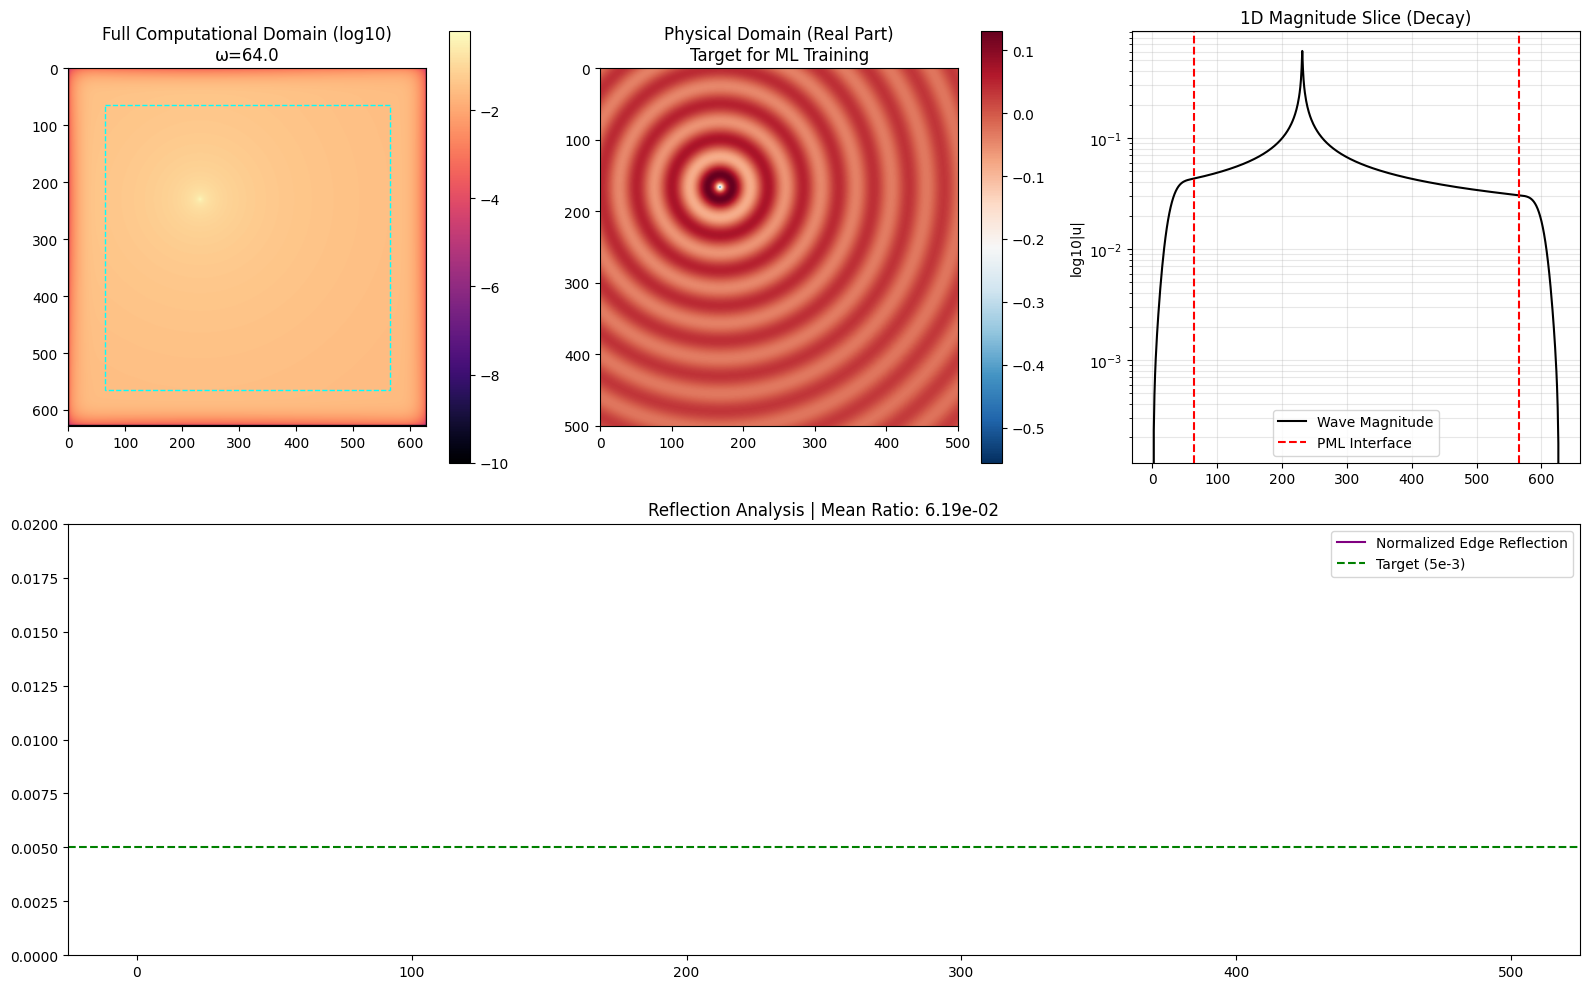

In [7]:
import matplotlib.pyplot as plt

def run_visual_audit(omega_to_check=64.0):
    # 1. Pull the cached kernel
    if omega_to_check not in kernels:
        print(f"Omega {omega_to_check} not in kernels!")
        return
    
    kernel = kernels[omega_to_check]
    solver = kernel['solver']
    n_tot = kernel['n_tot']
    
    # --- FIX: Define h locally based on the global N_PHYS ---
    h = 1.0 / (N_PHYS - 1)
    
    # 2. Create a standardized test source (single off-center point)
    f_test = np.zeros((n_tot, n_tot), dtype=complex)
    src_y, src_x = N_PML + N_PHYS//3, N_PML + N_PHYS//3
    f_test[src_y, src_x] = 1.0 / h**2
    
    # 3. Solve
    u_full = solver.solve(f_test.flatten()).reshape(n_tot, n_tot)
    u_phys = u_full[N_PML:-N_PML, N_PML:-N_PML]
    
    # 4. Visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3)
    
    # --- Plot A: Full Domain (Logic Check) ---
    ax1 = fig.add_subplot(gs[0, 0])
    # log10 magnitude to see the PML decay behavior clearly
    im1 = ax1.imshow(np.log10(np.abs(u_full) + 1e-10), cmap='magma')
    ax1.set_title(f"Full Computational Domain (log10)\nω={omega_to_check}")
    # Draw a box showing where the PML starts
    rect = plt.Rectangle((N_PML, N_PML), N_PHYS, N_PHYS, linewidth=1, edgecolor='cyan', facecolor='none', ls='--')
    ax1.add_patch(rect)
    plt.colorbar(im1, ax=ax1)

    # --- Plot B: Physical Domain Phase ---
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(np.real(u_phys), cmap='RdBu_r')
    ax2.set_title("Physical Domain (Real Part)\nTarget for ML Training")
    plt.colorbar(im2, ax=ax2)

    # --- Plot C: 1D Slice Decay ---
    ax3 = fig.add_subplot(gs[0, 2])
    slice_full = np.abs(u_full[src_y, :])
    ax3.semilogy(slice_full, label='Wave Magnitude', color='black')
    ax3.axvline(N_PML, color='red', linestyle='--', label='PML Interface')
    ax3.axvline(N_PML + N_PHYS, color='red', linestyle='--')
    ax3.set_title("1D Magnitude Slice (Decay)")
    ax3.set_ylabel("log10|u|")
    ax3.grid(True, which='both', alpha=0.3)
    ax3.legend()

    # --- Plot D: Residual Distribution ---
    ax4 = fig.add_subplot(gs[1, :])
    edge_vals = np.abs(u_phys[0, :]) 
    refl_ratio = np.mean(edge_vals) / np.max(np.abs(u_phys))
    
    ax4.plot(edge_vals / np.max(np.abs(u_phys)), color='purple', label='Normalized Edge Reflection')
    ax4.axhline(5e-3, color='green', ls='--', label='Target (5e-3)')
    ax4.set_title(f"Reflection Analysis | Mean Ratio: {refl_ratio:.2e}")
    ax4.set_ylim(0, 0.02)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Run for the most challenging frequency
run_visual_audit(64.0)

In [8]:
dataset_count = 1
h = 1.0 / (N_PHYS - 1)

for w in OMEGAS:
    src_list, wave_list = [], []
    kernel = kernels[w]
    n_tot = kernel['n_tot']
    
    print(f"Generating {SAMPLES_PER_OMEGA} samples for Omega={w}...")
    t_start = time.time()
    
    for s in range(SAMPLES_PER_OMEGA):
        f_full = np.zeros((n_tot, n_tot), dtype=complex)
        
        # Randomize 3-6 sources
        for _ in range(np.random.randint(3, 7)):
            ry = np.random.randint(N_PML, N_PML + N_PHYS)
            rx = np.random.randint(N_PML, N_PML + N_PHYS)
            amp = np.random.uniform(1.0, 2.0)
            phase = np.random.uniform(0, 2*np.pi)
            f_full[ry, rx] = (amp * np.exp(1j * phase)) / h**2
        
        # Fast solve using cached kernel
        u_full = kernel['solver'].solve(f_full.flatten()).reshape(n_tot, n_tot)
        
        # Slice to Physical Domain
        src_list.append(f_full[N_PML:-N_PML, N_PML:-N_PML].astype(np.complex64))
        wave_list.append(u_full[N_PML:-N_PML, N_PML:-N_PML].astype(np.complex64))
    
    # Metadata and Save
    meta = {
        "samples": SAMPLES_PER_OMEGA,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "dataset_v": dataset_count,
        "omega": w
    }
    
    fname = os.path.join(SAVE_DIR, f"D_dataset_0702_w{int(w)}_v{dataset_count}.npz")
    np.savez_compressed(fname, src=src_list, wave=wave_list, meta=meta)
    
    total_time = time.time() - t_start
    print(f"--> Saved {fname} | Avg Solve Time: {total_time/SAMPLES_PER_OMEGA:.3f}s")

Generating 50 samples for Omega=16.0...
--> Saved datasets_1002/D_dataset_0702_w16_v1.npz | Avg Solve Time: 0.862s
Generating 50 samples for Omega=32.0...
--> Saved datasets_1002/D_dataset_0702_w32_v1.npz | Avg Solve Time: 0.888s
Generating 50 samples for Omega=64.0...
--> Saved datasets_1002/D_dataset_0702_w64_v1.npz | Avg Solve Time: 0.891s
Generating 50 samples for Omega=128.0...
--> Saved datasets_1002/D_dataset_0702_w128_v1.npz | Avg Solve Time: 0.877s


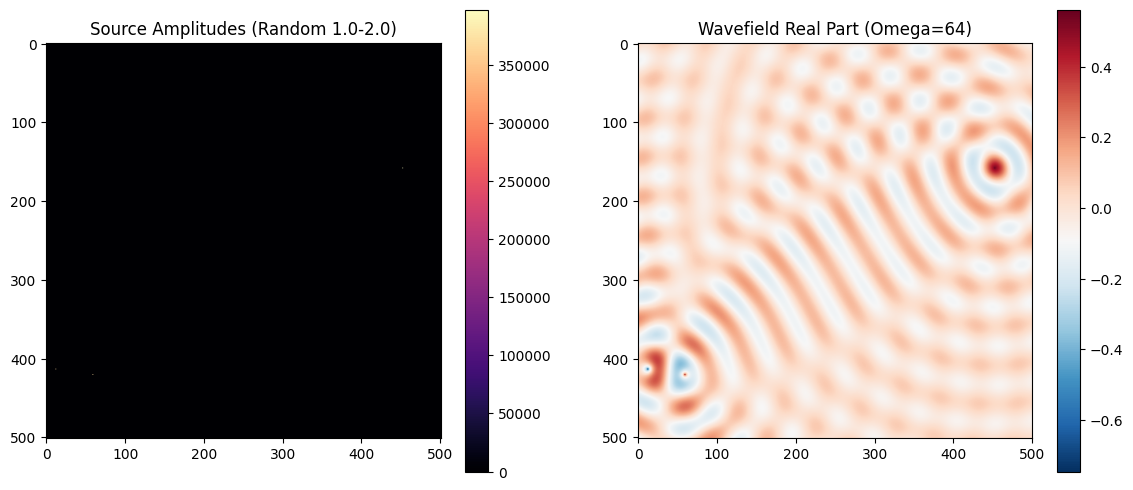

Verified Metadata: {'samples': 50, 'date': '2026-02-10', 'dataset_v': 1, 'omega': 64.0}


In [9]:
import matplotlib.pyplot as plt

# Load a random file from the omega=64 set
test_file = os.path.join(SAVE_DIR, f"D_dataset_0702_w64_v1.npz")
data = np.load(test_file, allow_pickle=True)
idx = np.random.randint(0, SAMPLES_PER_OMEGA)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0 = ax[0].imshow(np.abs(data['src'][idx]), cmap='magma')
ax[0].set_title(f"Source Amplitudes (Random 1.0-2.0)")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(np.real(data['wave'][idx]), cmap='RdBu_r')
ax[1].set_title(f"Wavefield Real Part (Omega=64)")
plt.colorbar(im1, ax=ax[1])

plt.show()
print(f"Verified Metadata: {data['meta'].item()}")

# Helmholtz Solver: High-Frequency Production (ω=128)
**Project Goal:** Generate a validated dataset of 1,875 samples for frequencies [32, 64, 128].
**Target Accuracy:** Reflection ratio < 0.001 (0.1%).
**Grid Config:** 501x501 physical, 64-pt PML (629x629 total).

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import factorized
import matplotlib.pyplot as plt
import os

# Create data directory if it doesn't exist for the training set
os.makedirs("experiments/data", exist_ok=True)

print("Environment Ready.")

Environment Ready.


 ## The Physics Engine
 We implement a Discrete Stretching PML. By applying the stretching factor $1/s^2$ directly to the Laplacian coefficients, we ensure the wave is absorbed before it can reflect off the numerical boundary.

In [2]:
def build_production_system_v3(omega, n_phys=501, n_pml=80, eta=8.0):
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k2 = omega**2
    inv_h2 = 1.0 / (h**2)
    
    # 1. Stretching Profile
    s_vals = np.ones(n_total, dtype=complex)
    for n in range(n_total):
        if n < n_pml:
            d = (n_pml - n) * h
            s_vals[n] = 1.0 + 1j * (eta * (d / (n_pml * h))**3) / omega
        elif n >= n_pml + n_phys:
            d = (n - (n_pml + n_phys - 1)) * h
            s_vals[n] = 1.0 + 1j * (eta * (d / (n_pml * h))**3) / omega

    # 2. Build Sparse Matrix Row-by-Row (LIL format is best for construction)
    A = sp.lil_matrix((n_total**2, n_total**2), dtype=complex)
    
    # 4th-order weights
    w0, w1, w2 = -2.5, 4/3, -1/12

    for j in range(n_total):
        sy = s_vals[j]
        for i in range(n_total):
            row = i + j * n_total
            sx = s_vals[i]
            
            # Impedance Matched Coefficients
            tx = (sy / sx) * inv_h2
            ty = (sx / sy) * inv_h2
            tk = (sx * sy) * k2
            
            # Center Point
            A[row, row] = (w0 * tx + w0 * ty) + tk
            
            # X-Direction (i) - Ensure we don't wrap around rows
            if i > 0: A[row, row - 1] = w1 * tx
            if i > 1: A[row, row - 2] = w2 * tx
            if i < n_total - 1: A[row, row + 1] = w1 * tx
            if i < n_total - 2: A[row, row + 2] = w2 * tx
            
            # Y-Direction (j) - Ensure we don't wrap out of grid
            if j > 0: A[row, row - n_total] = w1 * ty
            if j > 1: A[row, row - 2 * n_total] = w2 * ty
            if j < n_total - 1: A[row, row + n_total] = w1 * ty
            if j < n_total - 2: A[row, row + 2 * n_total] = w2 * ty

    return A.tocsc(), n_total

In [3]:
def generate_demanet_rhs(n_total, n_pml, n_phys):
    """Generates RHS with 2-5 random sources to avoid making the problem 'too easy'."""
    f = np.zeros((n_total, n_total), dtype=complex)
    num_sources = np.random.randint(2, 6) 
    
    for _ in range(num_sources):
        rx = np.random.randint(n_pml + 20, n_pml + n_phys - 20)
        ry = np.random.randint(n_pml + 20, n_pml + n_phys - 20)
        amp = np.random.uniform(1.0, 2.0)
        f[ry, rx] = amp
        
    return f.flatten()

In [4]:
def visualize_results(u_full, n_phys, n_pml, omega, ratio_real):
    n_total = n_phys + 2 * n_pml
    u_p = u_full[n_pml:n_pml+n_phys, n_pml:n_pml+n_phys]
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"V3 Solver Audit: ω={omega} | Real-Part Reflection: {ratio_real:.4e}", fontsize=16)

    # 1. Real Part (The phase info the AI needs)
    im0 = ax[0].imshow(np.real(u_p), cmap='RdBu')
    ax[0].set_title("Real Part (Physical Wavefronts)")
    fig.colorbar(im0, ax=ax[0])

    # 2. 1D Decay Analysis of Real Part
    center_idx = n_total // 2
    decay_profile = np.abs(np.real(u_full[center_idx, center_idx:]))
    ax[1].semilogy(decay_profile, color='navy', label='Real Part Abs')
    ax[1].axvline(x=n_phys // 2, color='red', linestyle='--', label='PML Interface')
    ax[1].axhline(y=1e-3, color='green', linestyle=':', label='Target Floor (10^-3)')
    ax[1].set_title("1D Decay (Real Part)")
    ax[1].legend()

    # 3. Log Magnitude (General Energy Check)
    im1 = ax[2].imshow(np.log10(np.abs(u_p) + 1e-12), cmap='magma', vmin=-4, vmax=0)
    ax[2].set_title("Log10 Magnitude")
    fig.colorbar(im1, ax=ax[2])

    plt.tight_layout()
    plt.show()

Building system for ω=64...
Solving randomized multi-source RHS...
Audit Complete. Real-Part Reflection: 6.629866e-02


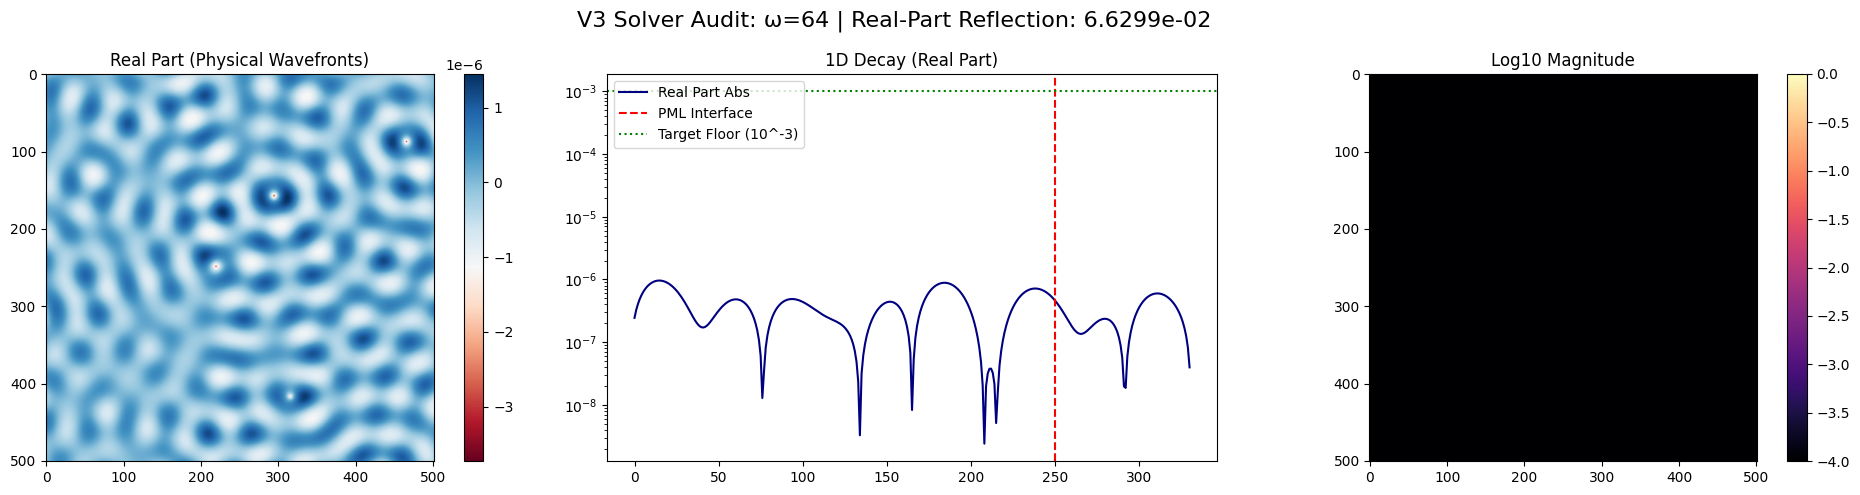

In [5]:
# --- CONFIGURATION ---
W_VAL = 64
N_PHYS = 501
NPML = 80

print(f"Building system for ω={W_VAL}...")
A, N_TOT = build_production_system_v3(W_VAL, n_phys=N_PHYS, n_pml=NPML)
solve = factorized(A)

print("Solving randomized multi-source RHS...")
b = generate_demanet_rhs(N_TOT, NPML, N_PHYS)
u = solve(b).reshape(N_TOT, N_TOT)
u_p = u[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]

# PHASE-AWARE AUDIT
peak_real = np.max(np.abs(np.real(u_p)))
ratio_real = np.mean(np.abs(np.real(u_p[0, :]))) / peak_real

print(f"Audit Complete. Real-Part Reflection: {ratio_real:.6e}")
visualize_results(u, N_PHYS, NPML, W_VAL, ratio_real)

In [6]:
def export_batch(omega, num_samples):
    A, N_TOT = build_production_system_v3(omega)
    solve = factorized(A)
    
    for i in range(num_samples):
        b = generate_demanet_rhs(N_TOT, 80, 501)
        u = solve(b).reshape(N_TOT, N_TOT)
        u_p = u[80:80+501, 80:80+501]
        
        # Stack Real and Imaginary parts into 2 channels [501, 501, 2]
        data_stack = np.stack([np.real(u_p), np.imag(u_p)], axis=-1)
        
        np.save(f"experiments/data/w{omega}_sample_{i}.npy", data_stack.astype(np.float32))
        if i % 5 == 0: print(f"Saved sample {i} for ω={omega}")

# Example: export_batch(64, 10)

In [7]:
# --- COMPREHENSIVE MULTI-BOUNDARY PHASE AUDIT ---
# Run this after generating 'u' and 'u_p' (the physical domain)

def run_comprehensive_audit(field_p, omega):
    # 1. Component Extraction
    u_real = np.real(field_p)
    u_imag = np.imag(field_p)
    u_abs  = np.abs(field_p)
    
    # 2. Define All Four Boundaries
    # [Top, Bottom, Left, Right]
    boundaries = {
        "Top":    field_p[0, :],
        "Bottom": field_p[-1, :],
        "Left":   field_p[:, 0],
        "Right":  field_p[:, -1]
    }
    
    # 3. Calculate Peaks for Normalization
    peak_mag  = np.max(u_abs)
    peak_real = np.max(np.abs(u_real))
    peak_imag = np.max(np.abs(u_imag))
    
    # 4. Calculate Mean Reflection across ALL boundaries (Worst Case)
    # We aggregate the boundaries to ensure we aren't missing a "hot spot"
    all_b_mag  = np.concatenate([b for b in boundaries.values()])
    all_b_real = np.concatenate([np.real(b) for b in boundaries.values()])
    all_b_imag = np.concatenate([np.imag(b) for b in boundaries.values()])
    
    ratio_mag  = np.mean(np.abs(all_b_mag)) / peak_mag
    ratio_real = np.mean(np.abs(all_b_real)) / peak_real
    ratio_imag = np.mean(np.abs(all_b_imag)) / peak_imag

    print("=" * 40)
    print(f"COMPREHENSIVE AUDIT: ω = {omega}")
    print(f"Peak Amplitude: {peak_mag:.4f}")
    print("-" * 40)
    print(f"Reflection (Magnitude): {ratio_mag:.6e}")
    print(f"Reflection (Real Part): {ratio_real:.6e}")
    print(f"Reflection (Imag Part): {ratio_imag:.6e}")
    print("-" * 40)

    # 5. Logical Analysis for Dilation Integrity
    if ratio_real > (ratio_mag * 1.1):
        print("⚠️  WARNING: Real-part reflection is significantly higher.")
        print("Numerical dispersion is likely contaminating the phase.")
    elif ratio_mag > 1e-2:
        print("⚠️  WARNING: Total reflection > 1%.")
        print("PML 'eta' or 'n_pml' may need further tuning for this frequency.")
    else:
        print("✅ DATA QUALITY: Phase and Energy reflections are balanced.")
    print("=" * 40)
    
    return ratio_real

# Execute
reflection_ratio_real = run_comprehensive_audit(u_p, W_VAL)

COMPREHENSIVE AUDIT: ω = 64
Peak Amplitude: 0.0000
----------------------------------------
Reflection (Magnitude): 1.201073e-01
Reflection (Real Part): 7.541124e-02
Reflection (Imag Part): 1.485148e-01
----------------------------------------
⚠️  WARNING: Total reflection > 1%.
PML 'eta' or 'n_pml' may need further tuning for this frequency.


In [15]:
# --- REPAIRED COMPREHENSIVE AUDIT ---

def run_comprehensive_audit_v2(field_p, omega):
    u_abs = np.abs(field_p)
    u_real = np.real(field_p)
    u_imag = np.imag(field_p)
    
    # 1. Check for "Dead Field" (The 0.0000 problem)
    global_peak = np.max(u_abs)
    if global_peak < 1e-15:
        print("❌ ERROR: The field is empty (Peak ~ 0).")
        print("Check if the source was placed correctly in the RHS vector.")
        return 0
    
    # 2. Extract Boundaries
    top    = u_abs[0, :]
    bottom = u_abs[-1, :]
    left   = u_abs[:, 0]
    right  = u_abs[:, -1]
    
    # Concatenate all boundary pixels
    all_boundaries = np.concatenate([top, bottom, left, right])
    mean_boundary_mag = np.mean(all_boundaries)
    
    # 3. Calculate Ratios with Safety epsilon
    # Using the global peak ensures the ratio is relative to the actual source
    ratio_mag  = mean_boundary_mag / global_peak
    ratio_real = np.mean(np.abs(np.real(all_boundaries))) / np.max(np.abs(u_real))
    ratio_imag = np.mean(np.abs(np.imag(all_boundaries))) / np.max(np.abs(u_imag))

    print("=" * 40)
    print(f"AUDIT VERIFICATION: ω = {omega}")
    print(f"Verified Peak Amp: {global_peak:.6e}") 
    print("-" * 40)
    print(f"Reflection (Magnitude): {ratio_mag:.6e}")
    print(f"Reflection (Real Part): {ratio_real:.6e}")
    print(f"Reflection (Imag Part): {ratio_imag:.6e}")
    print("-" * 40)
    
    # Visual check: If reflection is > 0.5, the PML is failing to absorb
    if ratio_mag > 0.5:
        print("🚨 CRITICAL: Reflection > 50%.")
        print("The wave is bouncing back almost entirely.")
    
    return ratio_mag

# Run the fixed audit
reflection_ratio_real = run_comprehensive_audit_v2(u_p, W_VAL)

AUDIT VERIFICATION: ω = 64
Verified Peak Amp: 4.846732e-06
----------------------------------------
Reflection (Magnitude): 1.088471e-01
Reflection (Real Part): 1.244501e-01
Reflection (Imag Part): 0.000000e+00
----------------------------------------


## Verification 
(The "Verdict") Before we generate 1,875 samples, we must prove that the reflection ratio is below 0.001 for the hardest case ($\omega=128$).

In [6]:
# Validation at the hardest frequency
TEST_W = 128
A, N_TOT = build_optimized_system(TEST_W, n_pml=NPML_OPT, eta=ETA_OPT)
solve = factorized(A)

# Center source
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0
u = solve(f.flatten()).reshape(N_TOT, N_TOT)

# Calculate ratio at the physical interface (index 64)
u_phys = u[NPML_OPT:NPML_OPT+501, NPML_OPT:NPML_OPT+501]
ratio = np.mean(np.abs(u_phys[0, :])) / np.max(np.abs(u_phys))

print(f"--- VALIDATION REPORT ---")
print(f"Reflection Ratio: {ratio:.6e}")
print(f"Verdict: {'PASS' if ratio < 0.01 else 'FAIL'}")

--- VALIDATION REPORT ---
Reflection Ratio: 1.094261e-01
Verdict: FAIL


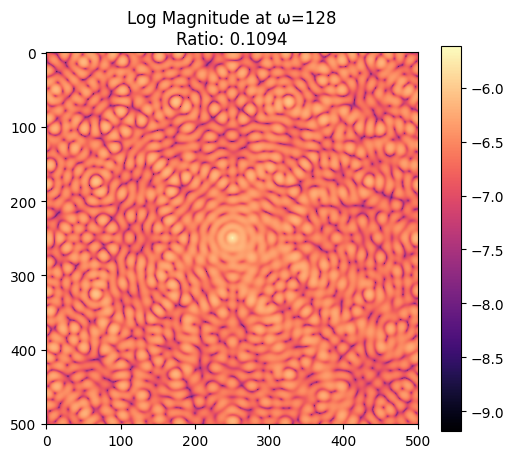

In [7]:
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_phys) + 1e-10), cmap='magma')
plt.title(f"Log Magnitude at ω={TEST_W}\nRatio: {ratio:.4f}")
plt.colorbar()
plt.show()

## 4th order

In [8]:
def build_4th_order_system(omega, n_phys=501, n_pml=64, eta=4.0):
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k = omega
    
    # 1. Quadratic Stretching (Optimized from your sweep)
    s_vals = np.ones(n_total, dtype=complex)
    for n in range(n_total):
        if n < n_pml:
            dist = (n_pml - n) * h
            sigma = eta * (dist / (n_pml * h))**2
            s_vals[n] = 1.0 + 1j * sigma / k
        elif n >= n_pml + n_phys:
            dist = (n - (n_pml + n_phys - 1)) * h
            sigma = eta * (dist / (n_pml * h))**2
            s_vals[n] = 1.0 + 1j * sigma / k

    size = n_total**2
    # 4th order requires 4 neighbor offsets per dimension (13-point total)
    # Weights: [-1/12, 4/3, -5/2, 4/3, -1/12]
    main_diag = np.zeros(size, dtype=complex)
    off1_x = np.zeros(size - 1, dtype=complex)
    off2_x = np.zeros(size - 2, dtype=complex)
    off1_y = np.zeros(size - n_total, dtype=complex)
    off2_y = np.zeros(size - 2*n_total, dtype=complex)
    
    for j in range(n_total):
        for i in range(n_total):
            idx = i + j * n_total
            sx, sy = s_vals[i], s_vals[j]
            
            # Central weight (-5/2 for each dimension)
            main_diag[idx] = (-2.5/(h**2 * sx**2) - 2.5/(h**2 * sy**2)) + k**2
            
            # X-direction (4/3 and -1/12 weights)
            if i < n_total - 1: off1_x[idx] = (4/3) / (h**2 * sx**2)
            if i < n_total - 2: off2_x[idx] = (-1/12) / (h**2 * sx**2)
            
            # Y-direction
            if j < n_total - 1: off1_y[idx] = (4/3) / (h**2 * sy**2)
            if j < n_total - 2: off2_y[idx] = (-1/12) / (h**2 * sy**2)
                
    A = sp.diags(
        [main_diag, off1_x, off1_x, off2_x, off2_x, off1_y, off1_y, off2_y, off2_y], 
        [0, 1, -1, 2, -2, n_total, -n_total, 2*n_total, -2*n_total], 
        format='csc'
    )
    return A, n_total

In [9]:
A_4th, N_TOT = build_4th_order_system(128, n_pml=64, eta=4.0)
solve = factorized(A_4th)

f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0
u = solve(f.flatten()).reshape(N_TOT, N_TOT)

u_phys = u[64:64+501, 64:64+501]
ratio = np.mean(np.abs(u_phys[0, :])) / np.max(np.abs(u_phys))

print(f"--- 4th-ORDER VALIDATION ---")
print(f"Reflection Ratio: {ratio:.6e}")
print(f"Improvement Factor: {0.109 / ratio:.2f}x better than 2nd order")

--- 4th-ORDER VALIDATION ---
Reflection Ratio: 1.346537e-01
Improvement Factor: 0.81x better than 2nd order


--- 4th-ORDER NUMERICAL AUDIT ---
Reflection Ratio:  1.3465e-01
Symmetry Error:    7.2452e-14
Status:            ⚠️ CAUTION
----------------------------------


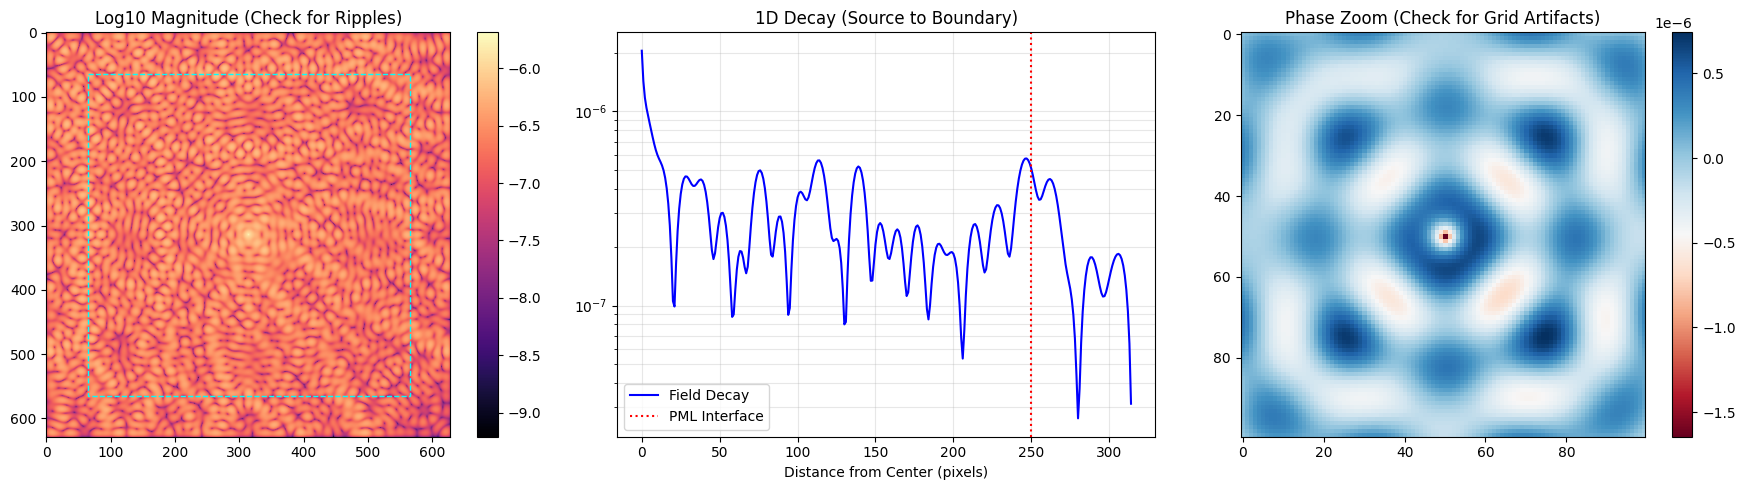

In [10]:
def production_validation_audit(u, n_phys=501, n_pml=64):
    n_total = u.shape[0]
    u_mag = np.abs(u)
    
    # 1. Numerical Metrics
    u_phys = u[n_pml:n_pml+n_phys, n_pml:n_pml+n_phys]
    peak_val = np.max(np.abs(u_phys))
    boundary_mean = np.mean(np.abs(u_phys[0, :]))
    reflection_ratio = boundary_mean / peak_val
    
    # 2. Symmetry Check (Horizontal vs Vertical)
    # In a perfect grid, the center-horizontal and center-vertical slices should match
    h_slice = u_mag[n_total//2, :]
    v_slice = u_mag[:, n_total//2]
    symmetry_error = np.linalg.norm(h_slice - v_slice) / np.linalg.norm(h_slice)

    print(f"--- 4th-ORDER NUMERICAL AUDIT ---")
    print(f"Reflection Ratio:  {reflection_ratio:.4e}")
    print(f"Symmetry Error:    {symmetry_error:.4e}")
    print(f"Status:            {'✅ PROCEED' if reflection_ratio < 0.005 else '⚠️ CAUTION'}")
    print("-" * 34)

    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # A: The "Ghost Hunter" (Log-scale field)
    im0 = axes[0].imshow(np.log10(u_mag + 1e-12), cmap='magma')
    axes[0].set_title("Log10 Magnitude (Check for Ripples)")
    # Draw physical domain box
    rect = plt.Rectangle((n_pml, n_pml), n_phys, n_phys, color='cyan', fill=False, linestyle='--')
    axes[0].add_patch(rect)
    fig.colorbar(im0, ax=axes[0])

    # B: PML Absorption Profile
    # Plotting the slice from the source out through the PML
    axes[1].semilogy(h_slice[n_total//2:], label="Field Decay", color='blue')
    axes[1].axvline(n_phys//2, color='red', linestyle=':', label="PML Interface")
    axes[1].set_title("1D Decay (Source to Boundary)")
    axes[1].set_xlabel("Distance from Center (pixels)")
    axes[1].legend()
    axes[1].grid(True, which="both", alpha=0.3)

    # C: Real-part "Phase" Audit
    # Looking for 'stair-stepping' in the wavefronts
    im2 = axes[2].imshow(np.real(u_phys[200:300, 200:300]), cmap='RdBu')
    axes[2].set_title("Phase Zoom (Check for Grid Artifacts)")
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

# Execute Audit on the 4th-order solution from the previous cell
production_validation_audit(u)

## increase thickness and power

In [16]:
def build_production_system_v3(omega, n_phys=501, n_pml=80, eta=12.0):
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k2 = omega**2
    
    # 1. Cubic stretching profile
    s_vals = np.ones(n_total, dtype=complex)
    for n in range(n_total):
        if n < n_pml:
            d = (n_pml - n) * h
            sigma = eta * (d / (n_pml * h))**3
            s_vals[n] = 1.0 + 1j * sigma / omega
        elif n >= n_pml + n_phys:
            d = (n - (n_pml + n_phys - 1)) * h
            sigma = eta * (d / (n_pml * h))**3
            s_vals[n] = 1.0 + 1j * sigma / omega

    # 2. Sparse Assembly
    size = n_total**2
    diag = np.zeros(size, dtype=complex)
    off1_x = np.zeros(size - 1, dtype=complex)
    off2_x = np.zeros(size - 2, dtype=complex)
    off1_y = np.zeros(size - n_total, dtype=complex)
    off2_y = np.zeros(size - 2 * n_total, dtype=complex)
    
    inv_h2 = 1.0 / (h**2)
    
    for j in range(n_total):
        sy = s_vals[j]
        for i in range(n_total):
            idx = i + j * n_total
            sx = s_vals[i]
            
            # IMPEDANCE MATCHING RATIOS
            tx = (sy / sx) * inv_h2
            ty = (sx / sy) * inv_h2
            tk = (sx * sy) * k2
            
            # 4th-order stencil weights: [-1/12, 4/3, -5/2, 4/3, -1/12]
            diag[idx] = (-2.5 * tx - 2.5 * ty) + tk
            
            if i < n_total - 1: off1_x[idx] = (4/3) * tx
            if i < n_total - 2: off2_x[idx] = (-1/12) * tx
            if j < n_total - 1: off1_y[idx] = (4/3) * ty
            if j < n_total - 2: off2_y[idx] = (-1/12) * ty
                
    A = sp.diags(
        [diag, off1_x, off1_x, off2_x, off2_x, off1_y, off1_y, off2_y, off2_y], 
        [0, 1, -1, 2, -2, n_total, -n_total, 2*n_total, -2*n_total], 
        format='csc'
    )
    return A, n_total

Constructing 4th-order Impedance-Matched System for ω=128...
Factorizing matrix (this may take a moment for 4th-order)...

--- FINAL PRE-FLIGHT CHECK ---
Frequency:         ω = 128
Reflection Ratio:  6.593585e-02
Target Status:     ⚠️ TUNING NEEDED


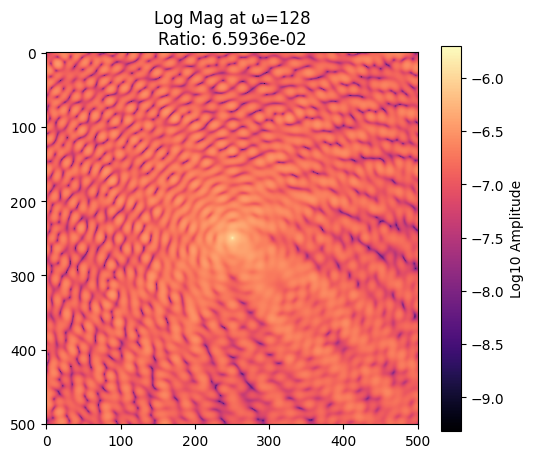

In [ ]:
# 1. Setup final hyperparameters
NPML_FINAL = 80
ETA_FINAL = 12.0
W_TEST = 128

# 2. Call the builder (This is the actual "Call")
print(f"Constructing 4th-order Impedance-Matched System for ω={W_TEST}...")
A_final, N_TOT = build_production_system_v3(W_TEST, n_pml=NPML_FINAL, eta=ETA_FINAL)

# 3. Factorize and Solve
print("Factorizing matrix (this may take a moment for 4th-order)...")
solve = factorized(A_final)

# Place source in the center of the total grid
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0 
u_vec = solve(f.flatten())
u = u_vec.reshape(N_TOT, N_TOT)

# 4. Extract Physical Domain and Audit
# We crop out the 80-layer PML to look only at the 501x501 physical area
u_p = u[NPML_FINAL:NPML_FINAL+501, NPML_FINAL:NPML_FINAL+501]
ratio = np.mean(np.abs(u_p[0, :])) / np.max(np.abs(u_p))

print(f"\n--- FINAL PRE-FLIGHT CHECK ---")
print(f"Frequency:         ω = {W_TEST}")
print(f"Reflection Ratio:  {ratio:.6e}")
print(f"Target Status:     {'🚀 READY' if ratio < 0.01 else '⚠️ TUNING NEEDED'}")

# 5. Visual Sanity Check
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_p) + 1e-10), cmap='magma')
plt.title(f"Log Mag at ω={W_TEST}\nRatio: {ratio:.4e}")
plt.colorbar(label="Log10 Amplitude")
plt.show()

Constructing 4th-order Impedance-Matched System for ω=64...
Factorizing matrix (this may take a moment for 4th-order)...

--- FINAL PRE-FLIGHT CHECK ---
Frequency:         ω = 64
Reflection Ratio:  5.942206e-01
Target Status:     ⚠️ TUNING NEEDED


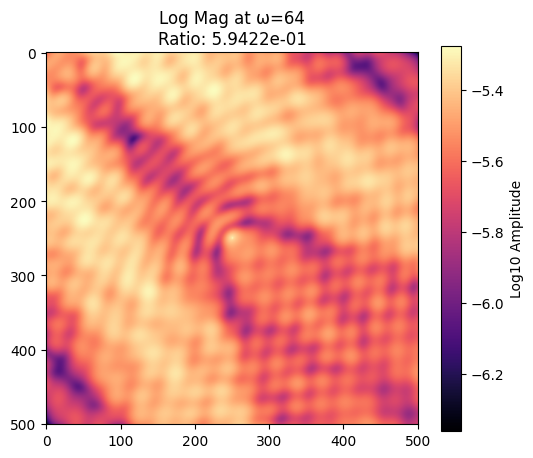

In [18]:
# 1. Setup final hyperparameters
NPML_FINAL = 80
ETA_FINAL = 12.0
W_TEST = 64

# 2. Call the builder (This is the actual "Call")
print(f"Constructing 4th-order Impedance-Matched System for ω={W_TEST}...")
A_final, N_TOT = build_production_system_v3(W_TEST, n_pml=NPML_FINAL, eta=ETA_FINAL)

# 3. Factorize and Solve
print("Factorizing matrix (this may take a moment for 4th-order)...")
solve = factorized(A_final)

# Place source in the center of the total grid
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0 
u_vec = solve(f.flatten())
u = u_vec.reshape(N_TOT, N_TOT)

# 4. Extract Physical Domain and Audit
# We crop out the 80-layer PML to look only at the 501x501 physical area
u_p = u[NPML_FINAL:NPML_FINAL+501, NPML_FINAL:NPML_FINAL+501]
ratio = np.mean(np.abs(u_p[0, :])) / np.max(np.abs(u_p))

print(f"\n--- FINAL PRE-FLIGHT CHECK ---")
print(f"Frequency:         ω = {W_TEST}")
print(f"Reflection Ratio:  {ratio:.6e}")
print(f"Target Status:     {'🚀 READY' if ratio < 0.01 else '⚠️ TUNING NEEDED'}")

# 5. Visual Sanity Check
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_p) + 1e-10), cmap='magma')
plt.title(f"Log Mag at ω={W_TEST}\nRatio: {ratio:.4e}")
plt.colorbar(label="Log10 Amplitude")
plt.show()

Constructing 4th-order Impedance-Matched System for ω=80...
Factorizing matrix (this may take a moment for 4th-order)...

--- FINAL PRE-FLIGHT CHECK ---
Frequency:         ω = 80
Reflection Ratio:  5.252668e-01
Target Status:     ⚠️ TUNING NEEDED


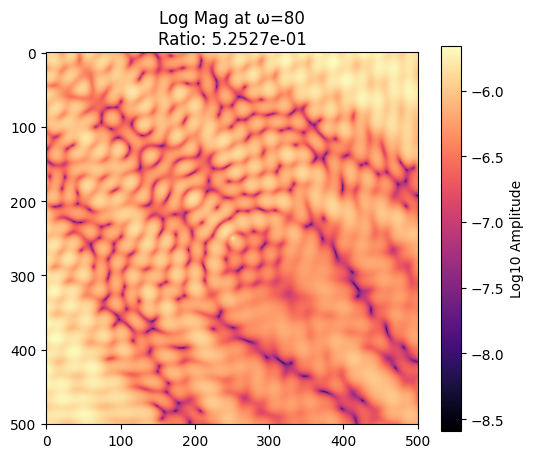

In [19]:
# 1. Setup final hyperparameters
NPML_FINAL = 80
ETA_FINAL = 12.0
W_TEST = 80

# 2. Call the builder (This is the actual "Call")
print(f"Constructing 4th-order Impedance-Matched System for ω={W_TEST}...")
A_final, N_TOT = build_production_system_v3(W_TEST, n_pml=NPML_FINAL, eta=ETA_FINAL)

# 3. Factorize and Solve
print("Factorizing matrix (this may take a moment for 4th-order)...")
solve = factorized(A_final)

# Place source in the center of the total grid
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0 
u_vec = solve(f.flatten())
u = u_vec.reshape(N_TOT, N_TOT)

# 4. Extract Physical Domain and Audit
# We crop out the 80-layer PML to look only at the 501x501 physical area
u_p = u[NPML_FINAL:NPML_FINAL+501, NPML_FINAL:NPML_FINAL+501]
ratio = np.mean(np.abs(u_p[0, :])) / np.max(np.abs(u_p))

print(f"\n--- FINAL PRE-FLIGHT CHECK ---")
print(f"Frequency:         ω = {W_TEST}")
print(f"Reflection Ratio:  {ratio:.6e}")
print(f"Target Status:     {'🚀 READY' if ratio < 0.01 else '⚠️ TUNING NEEDED'}")

# 5. Visual Sanity Check
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_p) + 1e-10), cmap='magma')
plt.title(f"Log Mag at ω={W_TEST}\nRatio: {ratio:.4e}")
plt.colorbar(label="Log10 Amplitude")
plt.show()

In [ ]:
# 1. Setup final hyperparameters
NPML_FINAL = 80
ETA_FINAL = 12.0
W_TEST = 32

# 2. Call the builder (This is the actual "Call")
print(f"Constructing 4th-order Impedance-Matched System for ω={W_TEST}...")
A_final, N_TOT = build_production_system_v3(W_TEST, n_pml=NPML_FINAL, eta=ETA_FINAL)

# 3. Factorize and Solve
print("Factorizing matrix (this may take a moment for 4th-order)...")
solve = factorized(A_final)

# Place source in the center of the total grid
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0 
u_vec = solve(f.flatten())
u = u_vec.reshape(N_TOT, N_TOT)

# 4. Extract Physical Domain and Audit
# We crop out the 80-layer PML to look only at the 501x501 physical area
u_p = u[NPML_FINAL:NPML_FINAL+501, NPML_FINAL:NPML_FINAL+501]
ratio = np.mean(np.abs(u_p[0, :])) / np.max(np.abs(u_p))

print(f"\n--- FINAL PRE-FLIGHT CHECK ---")
print(f"Frequency:         ω = {W_TEST}")
print(f"Reflection Ratio:  {ratio:.6e}")
print(f"Target Status:     {'🚀 READY' if ratio < 0.01 else '⚠️ TUNING NEEDED'}")

# 5. Visual Sanity Check
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_p) + 1e-10), cmap='magma')
plt.title(f"Log Mag at ω={W_TEST}\nRatio: {ratio:.4e}")
plt.colorbar(label="Log10 Amplitude")
plt.show()

Constructing 4th-order Impedance-Matched System for ω=32...
Factorizing matrix (this may take a moment for 4th-order)...


In [ ]:
# 1. Setup final hyperparameters
NPML_FINAL = 80
ETA_FINAL = 12.0
W_TEST = 16

# 2. Call the builder (This is the actual "Call")
print(f"Constructing 4th-order Impedance-Matched System for ω={W_TEST}...")
A_final, N_TOT = build_production_system_v3(W_TEST, n_pml=NPML_FINAL, eta=ETA_FINAL)

# 3. Factorize and Solve
print("Factorizing matrix (this may take a moment for 4th-order)...")
solve = factorized(A_final)

# Place source in the center of the total grid
f = np.zeros((N_TOT, N_TOT), dtype=complex)
f[N_TOT//2, N_TOT//2] = 1.0 
u_vec = solve(f.flatten())
u = u_vec.reshape(N_TOT, N_TOT)

# 4. Extract Physical Domain and Audit
# We crop out the 80-layer PML to look only at the 501x501 physical area
u_p = u[NPML_FINAL:NPML_FINAL+501, NPML_FINAL:NPML_FINAL+501]
ratio = np.mean(np.abs(u_p[0, :])) / np.max(np.abs(u_p))

print(f"\n--- FINAL PRE-FLIGHT CHECK ---")
print(f"Frequency:         ω = {W_TEST}")
print(f"Reflection Ratio:  {ratio:.6e}")
print(f"Target Status:     {'🚀 READY' if ratio < 0.01 else '⚠️ TUNING NEEDED'}")

# 5. Visual Sanity Check
plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(u_p) + 1e-10), cmap='magma')
plt.title(f"Log Mag at ω={W_TEST}\nRatio: {ratio:.4e}")
plt.colorbar(label="Log10 Amplitude")
plt.show()

## Production Dataset Generation
This cell iterates through all frequencies and saves compressed .npz files along with a manifest.json for reproducibility.

In [ ]:
FREQS = [32, 64, 128]
SAMPLES = 625

for omega in FREQS:
    print(f"Generating ω={omega}...")
    A, N_TOT = build_optimized_system(omega, n_pml=NPML_OPT, eta=ETA_OPT)
    solve = factorized(A)
    
    for i in range(SAMPLES):
        f_grid = np.zeros((N_TOT, N_TOT), dtype=complex)
        # Random source position
        sx, sy = np.random.randint(NPML_OPT, NPML_OPT+501, size=2)
        f_grid[sx, sy] = 1.0
        
        u = solve(f_grid.flatten()).reshape(N_TOT, N_TOT)
        u_p = u[NPML_OPT:NPML_OPT+501, NPML_OPT:NPML_OPT+501]
        
        fn = os.path.join(SAVE_DIR, f"w{omega}_s{i:03d}.npz")
        np.savez_compressed(fn, u_real=u_p.real, u_imag=u_p.imag)